# TODO

- ~~noisy~~
- ~~optimalizace diskretnich hyperparam - https://arxiv.org/pdf/1706.03673.pdf~~

- benchmark + proc approx?
- ~~paralelni EI~~
- expected imrpovement per second (vetsi hyperaram me stoji vic trenovani)
- v prubehu zjistim ze se mi to nelibi

- ~~kernely~~
- acquisition funkce

- matern kernel wtf???
- zkusit jestli torch.lbfgs je rychlejsi?

- stable eye vypnout
- funkce, merit nejlepsi kernel, ranky
- proc hyperparam opt kernelu nedojdou k stejnymu min (proc vubec vadi scaling?), tolerance
- jak moc paralelismus ovlivnuje
- rezy v nejlepsim vysledku bopt (marginal?)
- priory na parametry
- knowledge gradient, a dalsi???

- acquisition function heatmap

- podivat se na http://hyperopt.github.io/hyperopt/

In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
import random
import matplotlib.pyplot as plt

from numpy.linalg import solve, cholesky, inv
from numpy.random import multivariate_normal

from functools import partial

%matplotlib inline

from myopt.kernels import SquaredExp, RationalQuadratic, Linear, Matern
from myopt.gaussian_process import GaussianProcess, compute_optimized_kernel
from myopt.bayesian_optimization import bo_plot_exploration, bo_minimize, Integer, Float
from myopt.bayesian_optimization import plot_2d_optim_result, bo_minimize_parallel, bo_plot_exploration_parallel
from myopt.acquisition_functions import expected_improvement
from myopt.bayesian_optimization import propose_location
from myopt.opt_functions import get_opt_test_functions
import concurrent

executor = concurrent.futures.ThreadPoolExecutor(max_workers=1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In the basic form we have $K = k(X_{\text{train}}, X_{\text{train}}), K_* = k(X_{\text{train}}, X_{\text{test}}), K_{**} = k(X_{\text{test}}, X_{\text{test}})$, which gives us the following posterior

$$
\begin{align}
    \mu &= K_* K^{-1} y \\
    var &= K_{**} - K_* K^{-1} K_*^T.
\end{align}
$$

We can also write

$$
\begin{align}
    L &= cholesky(K) \\
    \alpha &= L^T \backslash (L \backslash y) \\
    \mu &= K_*^T \alpha \\
    v &= L \backslash K_* \\
    var &= K_{**} - v^T v,
\end{align}
$$

and we also know that

$$
(L \backslash K_*)^T (L \backslash y) = K_*^T (L^T \backslash (L \backslash y)) = K_* K^{-1} y
$$

## GP regression (ignoring noisy for now)

We condition on the training data and compute the posterior for the test data $X_{\text{test}}$. Since the posterior is Gaussian, it is fully defined by its mean and covariance, which we can compute in closed form

$$
\begin{align}
    \mu_* &= K_*^T K^{-1} y \\
    \Sigma_* &= K_{**} - K_*^T K^{-1} K_*
\end{align}
$$

In [240]:
X_train = np.array([0, 0.3, 2, 4])
y_train = np.sin(X_train)

X = np.arange(min(X_train) - 0.5, max(X_train) + 0.5, step=0.1)

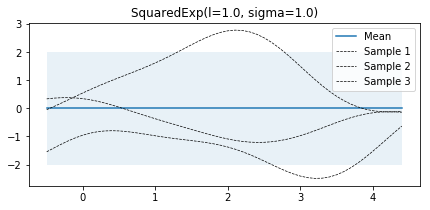

In [241]:
GaussianProcess().fit(np.array([]), np.array([])).optimize_kernel().posterior(X).plot_posterior()

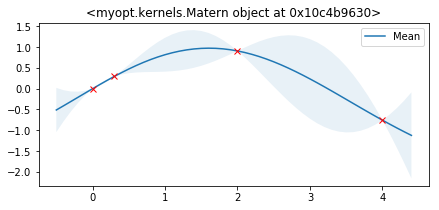

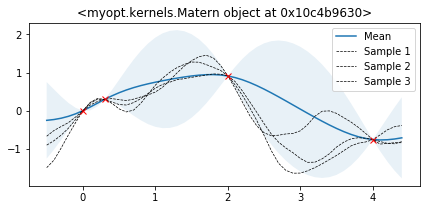

In [99]:
GaussianProcess(kernel=Matern(sigma=10, ro=5))\
        .posterior(X, X_train, y_train).plot_posterior(num_samples=0).optimize_kernel().posterior(X).plot_posterior()

SquaredExp(l=1, sigma=1)
RationalQuadratic(sigma=1, l=1, alpha=1)


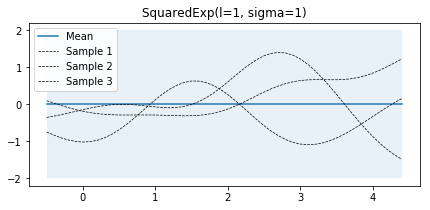

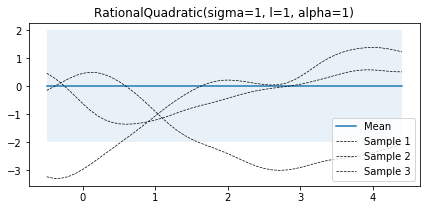

In [6]:
for k in [SquaredExp(), RationalQuadratic()]: #, Linear()]:
    print(k)
    GaussianProcess(kernel=k).plot_prior(X)

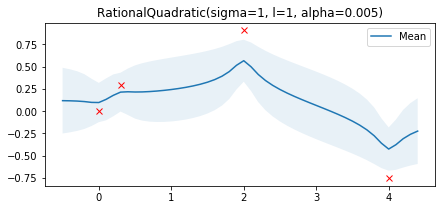

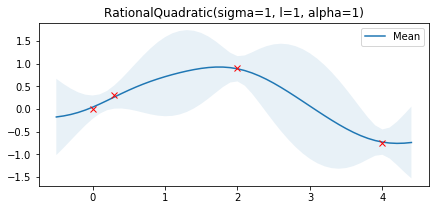

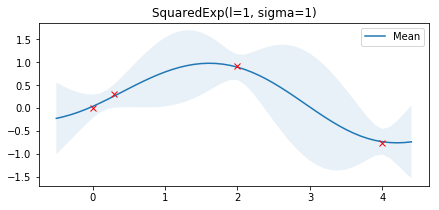

In [7]:
for kernel in [RationalQuadratic(alpha=0.005), RationalQuadratic(), SquaredExp()]: #, Linear()]:
    GaussianProcess(kernel=kernel).with_noise(.02)\
        .posterior(X, X_train, y_train).plot_posterior(num_samples=0)

## Big data (:

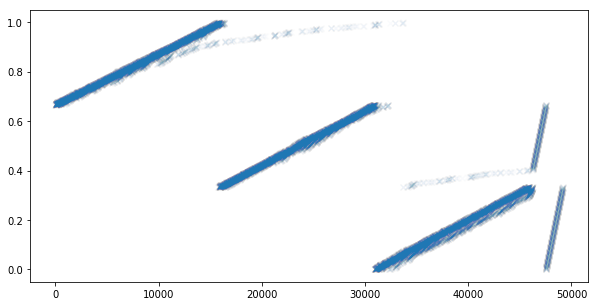

In [3]:
values = np.genfromtxt("matmul_faults.txt", converters={0:lambda s: int(s, 16)}, dtype=np.int64)
from sklearn.preprocessing import MinMaxScaler
values = MinMaxScaler().fit_transform(values.reshape(-1, 1).astype(np.float64))

plt.figure(figsize=(10,5))
plt.plot(values, "x", alpha=0.01)

In [5]:
offset = 0
num = 500
X = np.array(list(range(len(values))))[offset:offset + num]
y = values[offset:offset + num].reshape(-1)

y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
X = np.array(list(range(len(y))))


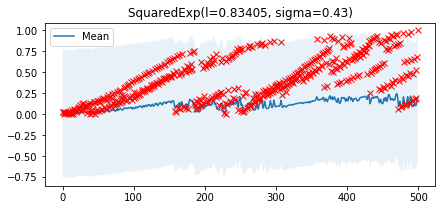

In [12]:
y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
X = np.array(list(range(len(y))))

gp = GaussianProcess(kernel=SquaredExp(), noise=1).fit(X, y).optimize_kernel().posterior(X)
gp.plot_posterior(num_samples=0)

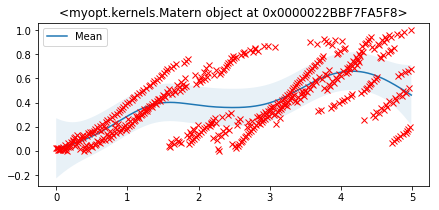

In [62]:
y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
X = np.array(list(range(len(y))))/100

gp = GaussianProcess(kernel=Matern(), noise=.5).fit(X, y).optimize_kernel().posterior(X)
gp.plot_posterior(num_samples=0)

In [205]:
from myopt.kernel_opt import plot_kernel_loss

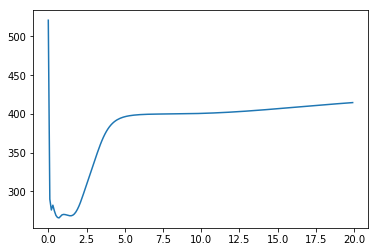

In [206]:
offset = 0
num = 500
X = np.array(list(range(len(values))))[offset:offset + num]
y = values[offset:offset + num].reshape(-1)

y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
X = np.array(list(range(len(y))))/100

plot_kernel_loss(SquaredExp(), X, y)

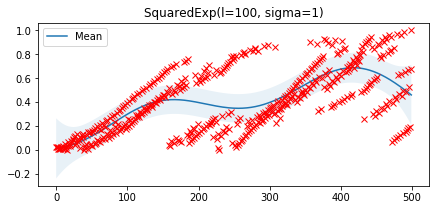

In [157]:
gp.with_kernel_params([100,1]).posterior(X).plot_posterior(num_samples=0)

## Kernel with rounding

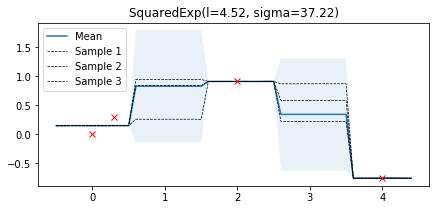

In [11]:
X_train = np.array([0, 0.3, 2, 4])
y_train = np.sin(X_train)

X = np.arange(min(X_train) - 0.5, max(X_train) + 0.5, step=0.1)

gp = GaussianProcess()
gp.kernel = gp.kernel.with_round_indexes(np.array([0]))
gp.posterior(X, X_train, y_train).plot_posterior()

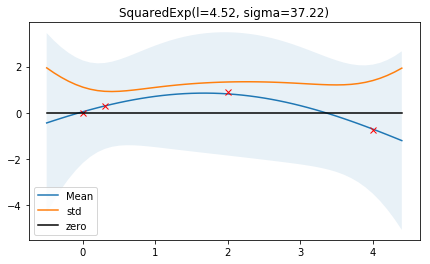

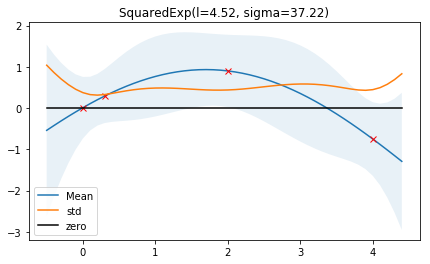

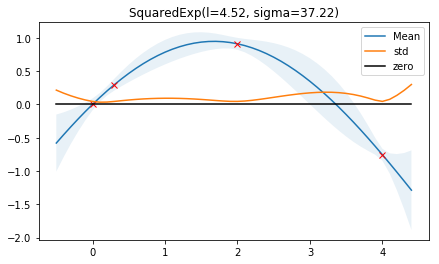

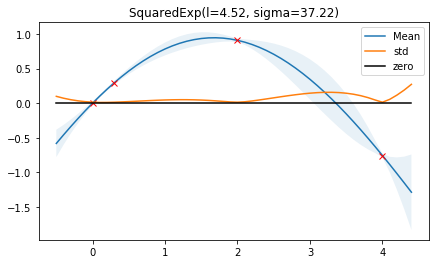

In [12]:
for noise in [2, 0.2, 0.002, 0.0002]:
    gp = GaussianProcess().with_noise(noise).posterior(X, X_train, y_train)
    plt.figure(figsize=(7,4))
    gp.plot_posterior(num_samples=0, figure=False)
    plt.plot(X, np.sqrt(np.diag(gp.cov)), label="std")
    plt.plot(X, np.zeros_like(X), label="zero", c="k")
    plt.legend()
    plt.show()

## Kernel params

<Figure size 1080x1080 with 0 Axes>

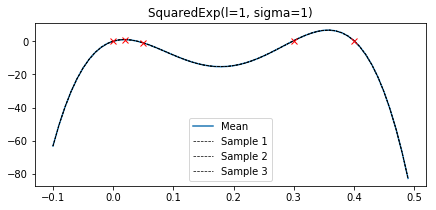

In [242]:
params = []# [0.1, 0.3, 0.6, 0.9, 2, 4]
X_train = np.array([0,0.02,0.05, 0.3, 0.4])
y_train = np.sin(X_train)
y_train[1] = 1
y_train[2] = -1

X = np.arange(min(X_train) - 0.1, max(X_train) + 0.1, step=0.01)
gp = GaussianProcess()

plt.figure(figsize=(15,15))
for i, l in enumerate(params):
    num_rows = len(params) // 2 + 1

    plt.subplot(num_rows, 2, i+1)
    
    gp.with_kernel_params([l, 1]).fit(X_train, y_train).posterior(X).plot_posterior(figure=False)

gp = gp.fit(X_train, y_train).with_kernel(SquaredExp()).posterior(X)
gp.plot_posterior()

In [243]:
gp.posterior(X_train).mu_std()

(array([-8.19401813e-08,  9.99999613e-01, -1.00000017e+00,  2.95520039e-01,
         3.89418467e-01]), array([0., 0., 0., 0., 0.]))

## Optimizing kernel parameters

$$
\begin{align}
    \log p(y|X) &= \log N(y|0, K_y) \\
                &= -\frac{1}{2} y^T K_y^{-1} y - \frac{1}{2} \log |K_y| - \frac{N}{2} \log(2 \pi)
\end{align}
$$

SquaredExp(l=2, sigma=1)

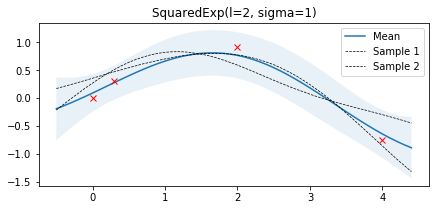

In [14]:
GaussianProcess(.05).fit(X_train, y_train)\
        .with_kernel_params([2, 1]).posterior(X).plot_posterior(num_samples=2).kernel

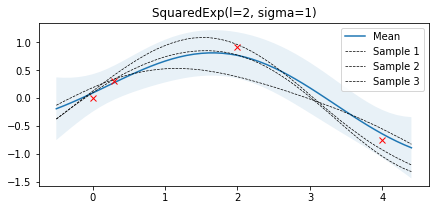

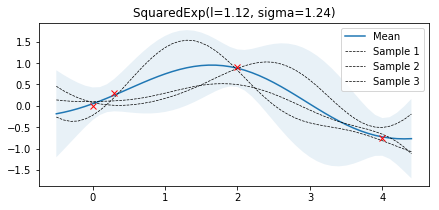

In [15]:
GaussianProcess(.05).fit(X_train, y_train)\
        .with_kernel_params([2, 1]).posterior(X).plot_posterior()\
        .optimize_kernel().posterior(X).plot_posterior()

## More general alternative to `np.meshgrid`

In [16]:
a = np.array([1,2]).reshape(-1, 1)
b = np.array([4,5]).reshape(1, -1)

a + b

array([[5, 6],
       [6, 7]])

In [17]:
a * b

array([[ 4,  5],
       [ 8, 10]])

## but how do I do this with tensordot on tensors?

In [18]:
a = np.array([[1,0],[2,0]]).reshape(-1, 1, 2)
b = np.array([[4,0],[5,0]]).reshape(1, -1, 2)

In [19]:
np.sqrt(((a - b) ** 2).sum(axis=2))

array([[3., 4.],
       [2., 3.]])

In [20]:
np.linalg.norm(a - b, axis=2)

array([[3., 4.],
       [2., 3.]])

In [21]:
np.tensordot(a, b, axes=2)

array([[4, 0],
       [8, 0]])

In [22]:
# This seems to work, but why are there the extra dimensions?
np.tensordot(a, b, axes=[2,2])

array([[[[ 4,  5]]],


       [[[ 8, 10]]]])

In [23]:
np.tensordot(a, b, axes=((1, 2), (0, 2)))

array([[ 4,  5],
       [ 8, 10]])

In [24]:
z = np.zeros((a.shape[0], b.shape[1]))

for i in range(a.shape[0]):
    for j in range(b.shape[1]): 
        z[i, j] = a[i, 0] @ b[0, j]

z

array([[ 4.,  5.],
       [ 8., 10.]])

In [25]:
a = np.array([[1,0],[2,0]]).reshape(-1, 1, 2)
b = np.array([[4,0],[5,0]]).reshape(1, -1, 2)

za = np.zeros_like(a)
zb = np.zeros_like(b)

aa = a + zb
bb = b + za

np.tensordot(aa, bb, axes=((1,2), (0,2)))
# array([[ 8,  0],
#        [16,  0]])

array([[ 8, 10],
       [16, 20]])

## Workaround with one loop

In [26]:
a = np.array([[1,0],[2,0]])
b = np.array([[4,0],[5,0]])

bb = b.T

rows = []

for i in range(a.shape[0]):
    rows.append(a[i] @ bb)

res = np.array(rows)

In [27]:
np.array(rows)

array([[ 4,  5],
       [ 8, 10]])

# Bayesian Optimization

http://krasserm.github.io/2018/03/21/bayesian-optimization/

In [68]:
bounds = [Float(-1.0, 2.0)]
noise = 0.2

def f(X):
    return -np.sin(3*X) - X**2 + 0.7*X

X_init = np.array([[-0.9], [1.1]])
y_init = f(X_init)

# Dense grid of points within bounds
X_true = np.arange(bounds[0].low, bounds[0].high, 0.01).reshape(-1, 1)

# Noise-free objective function values at X 
y_true = f(X_true)

noisy_f = lambda x: f(x).item() + random.random()*0.01

In [29]:
bo_minimize(noisy_f, bounds)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.99it/s]


max_x [-0.36484567] max max 0.5021895916410878


OptimizationResult(best_x=[-0.36484567], best_y=0.5021895916410878)

100%|██████████| 7/7 [00:01<00:00,  6.54it/s]

max_x [-0.36797002] max max 0.50331165462682


OptimizationResult(best_x=[-0.36797002], best_y=0.50331165462682)

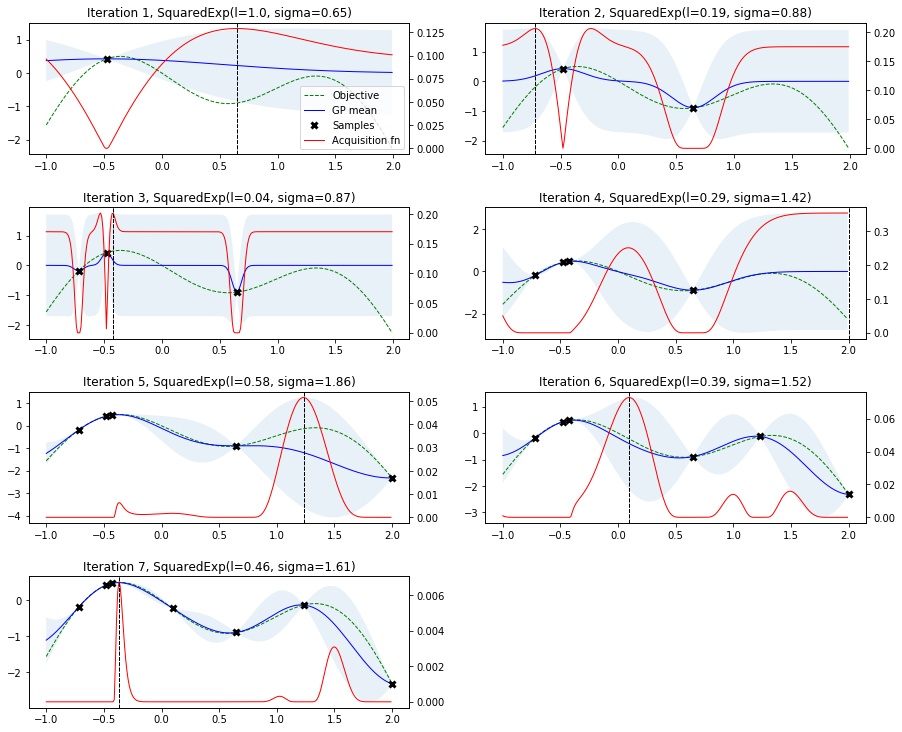

In [69]:
bo_plot_exploration(noisy_f, bounds, X_true=X_true, y_true=y_true, n_iter=8)

In [33]:
def parallel_f(x):
    return executor.submit(noisy_f, x)

In [34]:
bo_minimize(noisy_f, bounds)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.15it/s]


max_x [-0.36260049] max max 0.5099069004974306


OptimizationResult(best_x=[-0.36260049], best_y=0.5099069004974306)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.61it/s]


max_x [-0.17875602] max max 0.3593809326167657


OptimizationResult(best_x=[-0.17875602], best_y=0.3593809326167657)

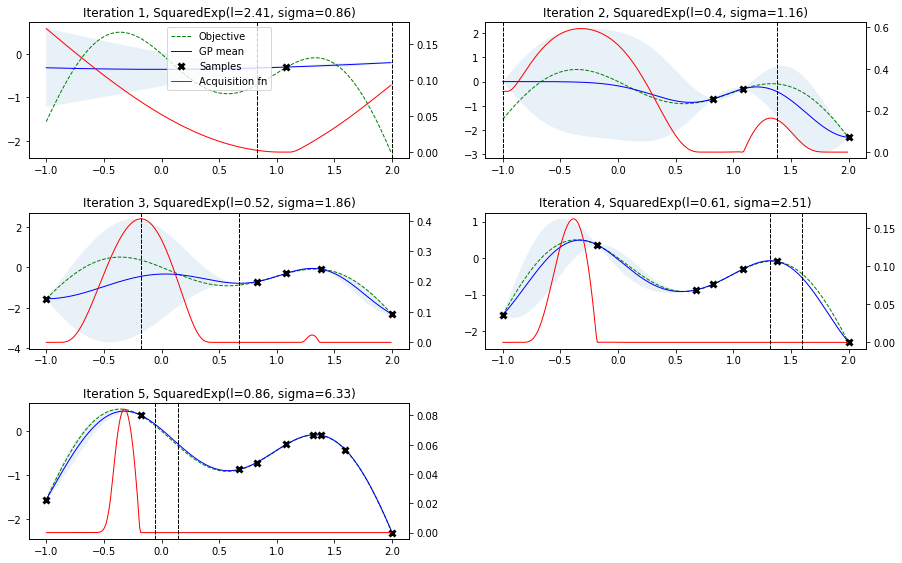

In [36]:
bo_plot_exploration_parallel(parallel_f, bounds, X_true=X_true, y_true=y_true, n_iter=10, n_parallel=2)

## GP benchmarks

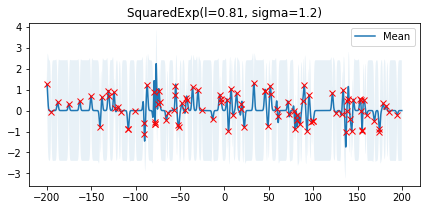

In [37]:
noise = 0.2

# Noisy training data
X_train = 400*np.random.rand(100) - 200
y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape)

X = np.arange(-200, 200, 0.2)
%prun GaussianProcess().fit(X_train, y_train).optimize_kernel().posterior(X).plot_posterior(num_samples=0)

Wall time: 2.19 s
Wall time: 15.7 s


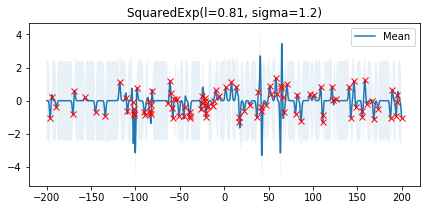

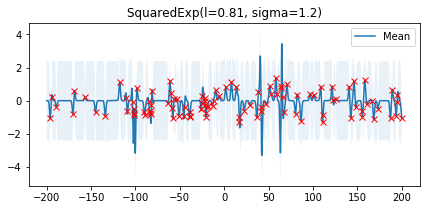

In [38]:
noise = 0.2

# Noisy training data
X_train = 400*np.random.rand(100) - 200
y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape)


X = np.arange(-200, 200, 0.2)
%time GaussianProcess().fit(X_train, y_train).posterior(X).plot_posterior(num_samples=0)

X = np.arange(-200, 200, 0.1)
%time GaussianProcess().fit(X_train, y_train).posterior(X).plot_posterior(num_samples=0)

## 2D bayes opt

In [11]:
get_
    

[OptFunction(name='Beale', max=0.0, f=<function beale.<locals>.f at 0x000001207D2B0EA0>, parallel_f=<function beale.<locals>.parallel_f at 0x000001207D2B0F28>, bounds=[<myopt.bayesian_optimization.Float object at 0x000001207A7238D0>, <myopt.bayesian_optimization.Float object at 0x000001207A7237F0>]),
 OptFunction(name='Easom', max=1.0, f=<function easom.<locals>.f at 0x000001207D2B0B70>, parallel_f=<function easom.<locals>.parallel_f at 0x000001207D2B0D08>, bounds=[<myopt.bayesian_optimization.Float object at 0x000001207A723128>, <myopt.bayesian_optimization.Float object at 0x000001207A723F98>]),
 OptFunction(name='Eggholder', max=959.6407, f=<function eggholder.<locals>.f at 0x000001207D2B0AE8>, parallel_f=<function eggholder.<locals>.parallel_f at 0x000001207D2B0E18>, bounds=[<myopt.bayesian_optimization.Float object at 0x000001207A723FD0>, <myopt.bayesian_optimization.Float object at 0x000001207A7232B0>]),
 OptFunction(name='McCormick', max=19.2085, f=<function mccormick.<locals>.f 

In [2]:
def f(x):
    y = x[1] * 10
    x = x[0] * 10
    
    val = -(y + 47) * np.sin(np.sqrt(np.abs(x/2 + (y + 47)))) - x * np.sin(np.sqrt(np.abs(x - (y + 47))))
    return -val.item()

def ff(x):
    return np.sin(np.linalg.norm(x)).item()

def parallel_f(x):
    return executor.submit(f, x)

# bounds = [Integer(-5, 8), Float(-2, 3), Float(0, 10), Integer(2, 10), Float(-2, 3), Float(0, 10), Integer(2, 10), Float(-2, 3), Float(0, 10), Integer(2, 10)]
bounds = [Float(-5, 5), Float(-10, 5)]

# res = bo_minimize(f, bounds, n_iter=30, kernel=SquaredExp())

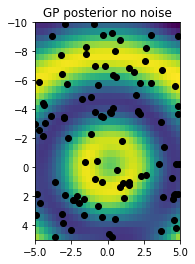

In [33]:
bounds = [Float(-5, 5), Float(-10, 5)]

from myopt.plot import plot_gp_2D
from mpl_toolkits.mplot3d import axes3d, Axes3D

noise_2d = 0.01

rx, ry = np.arange(-5, 5, 0.3), np.arange(-10, 5, 0.45)
gx, gy = np.meshgrid(rx, ry)

X_2d = np.c_[gx.ravel(), gy.ravel()]

X_2d_train = np.array([np.array([bound.sample() for bound in bounds]) for _ in range(100)])
# X_2d_train = np.random.uniform(-4, 4, (200, 2))
y_2d_train = np.sin(np.linalg.norm(X_2d_train, axis=1))# + noise_2d * np.random.randn(len(X_2d_train))

mu_s, _ = GaussianProcess(noise=0).fit(X_2d_train, y_2d_train).optimize_kernel().posterior(X_2d).mu_std()

b1=bounds[0]
b2 = bounds[1]

plt.figure(figsize=(12, 4))
plt.subplot(131); plt.title("GP posterior no noise");
plt.scatter(X_2d_train[:,0], X_2d_train[:,1], c="k")
plt.imshow(mu_s.reshape(gx.shape[0], gy.shape[0]), extent=[b1.low, b1.high, b2.high, b2.low])

gp = GaussianProcess(noise=0.01).fit(X_2d_train, y_2d_train).optimize_kernel().posterior(X_2d)
mu_s, _ = gp.mu_std()

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.18s/it]


max_x [-4.70014096  3.83652552] max max 126.39144704451707


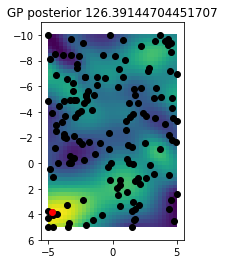

In [4]:
res = bo_minimize_parallel(parallel_f, bounds, n_iter=150, kernel=Matern(), gp_noise=0.05)
plot_2d_optim_result(res)

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 25.90it/s]


max_x [-3.35556186  3.08451019] max max 108.13094580916938


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 20.91it/s]


max_x [-4.08777654  3.95666941] max max 122.37404712579098


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 24.03it/s]


max_x [-3.63053825  2.58026085] max max 96.13827151421748


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 23.87it/s]


max_x [-3.65974458  4.22604708] max max 110.84408009324297


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 24.67it/s]


max_x [-3.00094744  3.8003331 ] max max 102.99363220679827


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 24.73it/s]


max_x [ 3.20382554 -8.49786106] max max 65.86979015768276


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 27.47it/s]


max_x [-3.28030948  4.34221387] max max 98.81124246264957


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 26.87it/s]


max_x [0.99692876 1.50267531] max max 66.64115162633928


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 26.14it/s]


max_x [-2.16275701  3.05348889] max max 84.73045469126271


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 25.07it/s]


max_x [-3.45756669  4.09662423] max max 109.33246566730054


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 24.28it/s]


max_x [ 3.19169571 -8.52606636] max max 65.90553087674708


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 27.41it/s]


max_x [-3.14258297  3.01722826] max max 103.54460633463431


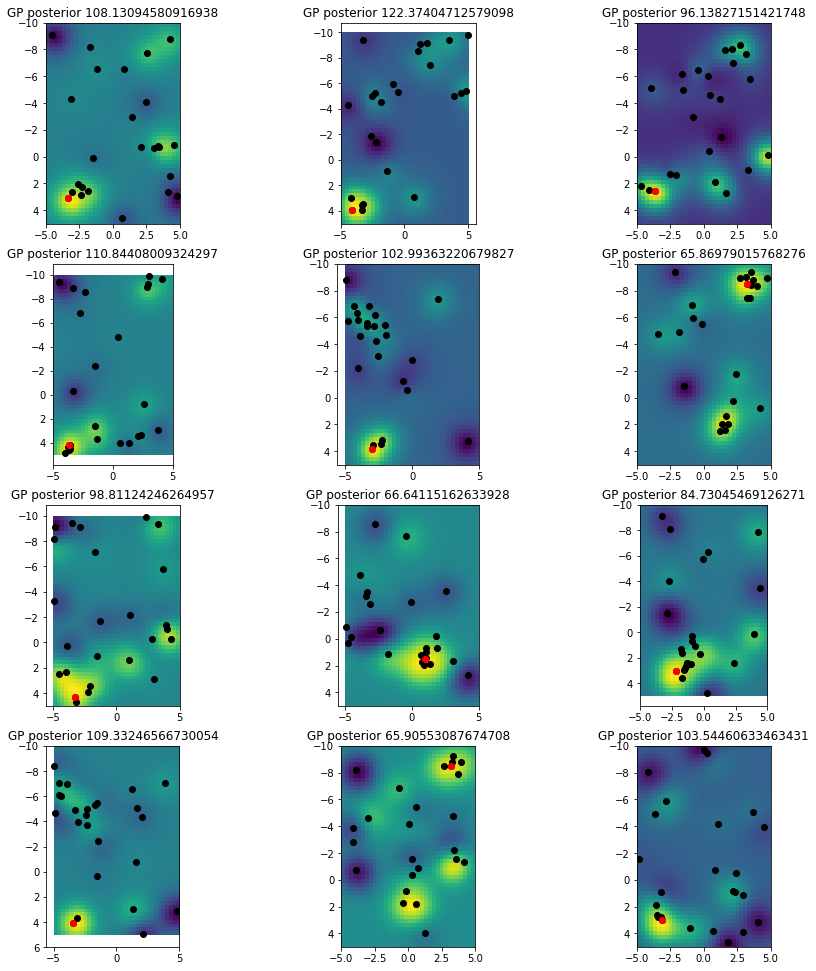

In [44]:
plt.figure(figsize=(15,17))
results = []
for i in range(12):    
#     res = bo_minimize_parallel(parallel_f, bounds, n_iter=25, kernel=Matern() if i < 6 else SquaredExp(), gp_noise=0.05, n_parallel=5)
    res = bo_minimize(f, bounds, n_iter=25, kernel=Matern() if i < 6 else SquaredExp(), gp_noise=0.05, optimize_kernel=False)
    results.append(res)
    plt.subplot(4,3,i+1)
    plot_2d_optim_result(res)

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:08<00:00,  2.73it/s]


max_x [-4.67079316  3.84112982] max max 126.40565987643893


 12%|██████████▍                                                                        | 3/24 [00:01<00:08,  2.49it/s]


KeyboardInterrupt: 

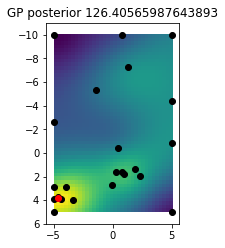

In [45]:
plt.figure(figsize=(15,17))
results = []
for i in range(12):    
#     res = bo_minimize_parallel(parallel_f, bounds, n_iter=25, kernel=Matern() if i < 6 else SquaredExp(), gp_noise=0.05, n_parallel=5)
    res = bo_minimize(f, bounds, n_iter=25, kernel=Matern() if i < 6 else SquaredExp(), gp_noise=0.05)
    results.append(res)
    plt.subplot(4,3,i+1)
    plot_2d_optim_result(res)

In [109]:
res

OptimizationResult(best_x=[ 0.99999685 -7.78723077], best_y=0.9999960628083637)

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:03<00:00,  6.39it/s]


max_x [459.80661432 460.62281373] max max 727.7630257533756


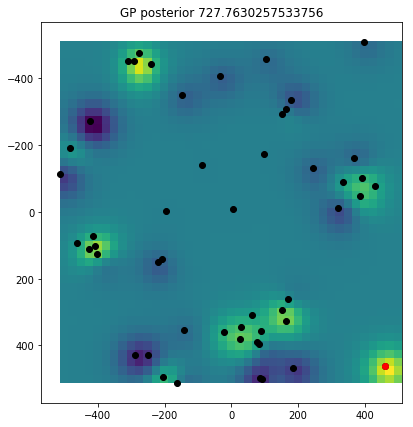

In [55]:
def f(x):
    return np.sin(np.linalg.norm(x)).item()

def parallel_f(x):
    return executor.submit(f, x)

def f(x):
    y = x[1]
    x = x[0]
    
    val = -(y + 47) * np.sin(np.sqrt(np.abs(x/2 + (y + 47)))) - x * np.sin(np.sqrt(np.abs(x - (y + 47))))
    return -val.item()

def parallel_f(x):
    return executor.submit(f, x)


bounds = [Float(-512, 512), Float(-512, 512)]

plt.figure(figsize=(10,7))
res = bo_minimize_parallel(parallel_f, bounds, n_iter=50, kernel=Matern(), gp_noise=0.05, n_parallel=2)
results.append(res)
plot_2d_optim_result(res, resolution=25)

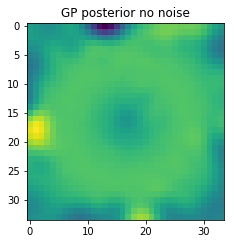

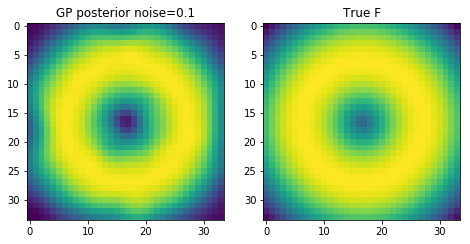

In [43]:
from myopt.plot import plot_gp_2D
from mpl_toolkits.mplot3d import axes3d, Axes3D

noise_2d = 0.01

rx, ry = np.arange(-5, 5, 0.3), np.arange(-5, 5, 0.3)
gx, gy = np.meshgrid(rx, rx)

X_2d = np.c_[gx.ravel(), gy.ravel()]

X_2d_train = np.random.uniform(-4, 4, (200, 2))
y_2d_train = np.sin(0.5 * np.linalg.norm(X_2d_train, axis=1))# + noise_2d * np.random.randn(len(X_2d_train))

mu_s, _ = GaussianProcess(noise=0).fit(X_2d_train, y_2d_train).optimize_kernel().posterior(X_2d).mu_std()

plt.figure(figsize=(12, 4))
plt.subplot(131); plt.title("GP posterior no noise");
plt.imshow(mu_s.reshape(gx.shape[0], gy.shape[0]))

gp = GaussianProcess(noise=0.01).fit(X_2d_train, y_2d_train).optimize_kernel().posterior(X_2d)
mu_s, _ = gp.mu_std()

plt.figure(figsize=(12, 4))
plt.subplot(132); plt.title("GP posterior noise=0.1");
plt.imshow(mu_s.reshape(gx.shape[0], gy.shape[0]))


plt.subplot(133); plt.title("True F");
plt.imshow(np.sin(0.5 * np.linalg.norm(X_2d, axis=1)).reshape(gx.shape[0], gy.shape[0]))

In [44]:
gp.posterior(np.array([[0,2]])).mu_std()

(array([0.85605834]), array([0.15718376]))

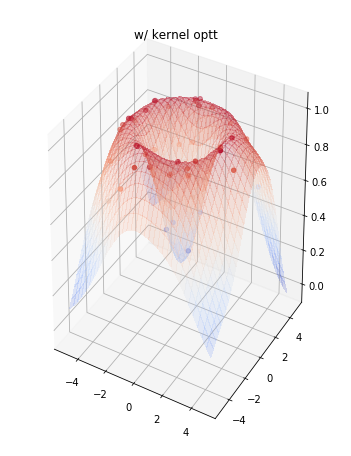

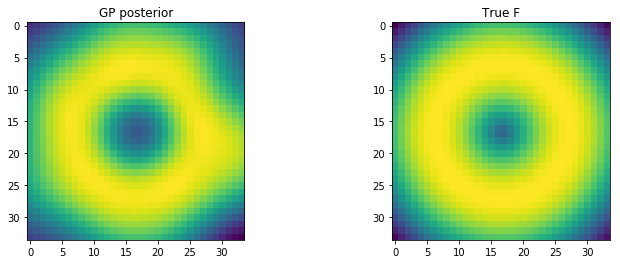

In [45]:
from myopt.plot import plot_gp_2D
from mpl_toolkits.mplot3d import axes3d, Axes3D

noise_2d = 0.01

rx, ry = np.arange(-5, 5, 0.3), np.arange(-5, 5, 0.3)
gx, gy = np.meshgrid(rx, rx)

X_2d = np.c_[gx.ravel(), gy.ravel()]

X_2d_train = np.random.uniform(-4, 4, (50, 2))
y_2d_train = np.sin(0.5 * np.linalg.norm(X_2d_train, axis=1))# + noise_2d * np.random.randn(len(X_2d_train))

mu_s, _ = GaussianProcess(noise=0.01).fit(X_2d_train, y_2d_train).optimize_kernel().posterior(X_2d).mu_std()

plt.figure(figsize=(13,8))
plot_gp_2D(gx, gy, mu_s, X_2d_train, y_2d_train, "w/ kernel optt", 1)

plt.figure(figsize=(12, 4))
plt.subplot(121); plt.title("GP posterior"); plt.imshow(mu_s.reshape(gx.shape[0], gy.shape[0]))
plt.subplot(122); plt.title("True F"); plt.imshow(np.sin(0.5 * np.linalg.norm(X_2d, axis=1)).reshape(gx.shape[0], gy.shape[0]))
